In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir  ~/.kaggle   

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! mkdir train

In [ ]:
!kaggle datasets download -d manideep1108/tusimple

100% 21.6G/21.6G [03:27<00:00, 175MB/s]
100% 21.6G/21.6G [03:27<00:00, 112MB/s]


In [ ]:
!unzip tusimple.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/TUSimple/train_set/clips/0313-2/33480/14.jpg  
  inflating: train/TUSimple/train_set/clips/0313-2/33480/15.jpg  
  inflating: train/TUSimple/train_set/clips/0313-2/33480/16.jpg  
  inflating: train/TUSimple/train_set/clips/0313-2/33480/17.jpg  
  inflating: train/TUSimple/train_set/clips/0313-2/33480/18.jpg  
  inflating: train/TUSimple/train_set/clips/0313-2/33480/19.jpg  
  inflating: train/TUSimple/train_set/clips/0313-2/33480/2.jpg  
  inflating: train/TUSimple/train_set/clips/0313-2/33480/20.jpg  
  inflating: train/TUSimple/train_set/clips/0313-2/33480/3.jpg  
  inflating: train/TUSimple/train_set/clips/0313-2/33480/4.jpg  
  inflating: train/TUSimple/train_set/clips/0313-2/33480/5.jpg  
  inflating: train/TUSimple/train_set/clips/0313-2/33480/6.jpg  
  inflating: train/TUSimple/train_set/clips/0313-2/33480/7.jpg  
  inflating: train/TUSimple/train_set/clips/0313-2/33480/8.jpg  
  inflating: train/TUSimple/trai

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


GAN

Will generate 128px square images.
Looking for file: /content/drive/MyDrive/right/training_data_128_128.npy
Loading previous training pickle...
tf.Tensor([[0.5003159]], shape=(1, 1), dtype=float32)
Epoch 1, gen loss=1.4126293659210205,disc loss=1.8631913661956787, {hms_string(epoch_elapsed)}
Epoch 2, gen loss=0.09673503786325455,disc loss=2.9096341133117676, {hms_string(epoch_elapsed)}
Epoch 3, gen loss=2.50834321975708,disc loss=0.21201087534427643, {hms_string(epoch_elapsed)}
Epoch 4, gen loss=5.771717548370361,disc loss=0.381209135055542, {hms_string(epoch_elapsed)}
Epoch 5, gen loss=5.223366737365723,disc loss=0.02727172151207924, {hms_string(epoch_elapsed)}
Epoch 6, gen loss=4.06207275390625,disc loss=0.037344496697187424, {hms_string(epoch_elapsed)}
Epoch 7, gen loss=3.650930404663086,disc loss=0.05261070281267166, {hms_string(epoch_elapsed)}
Epoch 8, gen loss=3.4238290786743164,disc loss=0.08763083815574646, {hms_string(epoch_elapsed)}
Epoch 9, gen loss=4.028841018676758,disc lo

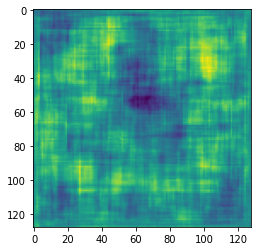

In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

GENERATE_RES = 4 
GENERATE_SQUARE = 32 * GENERATE_RES 
IMAGE_CHANNELS = 3

PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16
SEED_SIZE = 100

DATA_PATH = '/content/drive/MyDrive/right'
EPOCHS = 1000
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)



training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

#shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(255,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(255,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(255,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

train(train_dataset, EPOCHS)

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if device==torch.device("cuda"):
    print("Using device:", torch.cuda.get_device_name(0))
else:
    print("Using device:", device)

def set_gpu_number(n_gpu):
    global device
    device = torch.device("cuda:{}".format(n_gpu)) if torch.cuda.is_available() else torch.device("cpu")

Using device: Tesla T4


LSTM

In [ ]:

import torch.nn as nn
from torch.autograd import Variable
import torch

class ConvLSTMCell(nn.Module):
 
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias):

        super(ConvLSTMCell, self).__init__()

        self.row, self.col = input_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,  
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)  

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(batch_size, self.hidden_dim, self.row, self.col)).to(device),
                Variable(torch.zeros(batch_size, self.hidden_dim, self.row, self.col)).to(device))


class ConvLSTM(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = input_size

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_size=(self.height, self.width),
                                          input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):

        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

     
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=input_tensor.size(0))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:] 

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers

        return param


LANE DEPARTURE WARNING SYSTEM

In [ ]:
#LDWS
import cv2
import numpy as np
from math import atan
from google.colab.patches import cv2_imshow

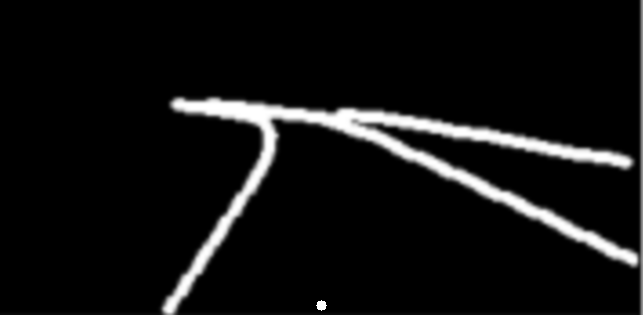

In [ ]:
img = cv2.imread('/content/w3.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
originY, originX = 0, 0
height, width = blur_gray.shape[:2]
(centerX, centerY) = (width // 2, height // 2)
blur_gray = cv2.circle(blur_gray,(centerX, height-10) , 0, (255,0,0), 10)
cv2_imshow(blur_gray)

In [ ]:
def trig_form(image,start_point,end_point): 
  color = (255,0, 0)
  thickness = 5
  image = cv2.line(image, start_point, end_point, color, thickness)
  
for i in range(centerX-10,0,-1):
  if blur_gray[height-10,i] > 0:
    x = i
    break
for i in range(centerX+10,width):
  if blur_gray[height-10,i] > 0:
    y = i
    break
lp = (x,height-10)
rp = (y,height-10)
mp = (centerX, height-10)
print("LEFT POINT: ",lp)
print("MID-PONT: ",mp)
print("RIGHT POINT: ",rp)

LEFT POINT:  (183, 305)
MID-PONT:  (321, 305)
RIGHT POINT:  (637, 305)


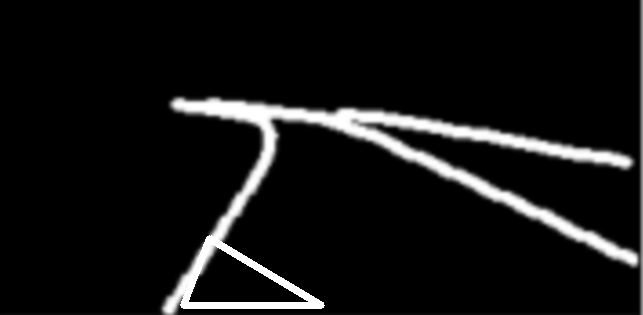

Left Deviation
OFFSET:  -1.960352422907489 m
28.84015621889069
DEVIATION ANGLE:  61.15984378110931
HAPPY JOURNEY!


In [ ]:
import math
from re import S

def slope(x1, y1, x2, y2):
    return (float)(y2-y1)/(x2-x1)

def findAngle(M1, M2):
    PI = 3.14159265
    angle = abs((M2 - M1) / (1 + M1 * M2))
    ret = atan(angle)
    val = (ret * 180) / PI
    return (round(val, 4))

def euc_dis(x,y):
  return np.sqrt((((x[0]-y[0])**2)) + (((x[1]-y[1])**2)))

def dev_ang(a,b,c):
  w = math.atan(euc_dis(a,b)/euc_dis(b,c))
  w = math.degrees(w)
  print(w)
  print("DEVIATION ANGLE: ",90-w)


lpd = euc_dis(mp,lp)
rpd = euc_dis(mp,rp)
wid_lane = lpd+rpd
# print(lpd,rpd,wid_lane)
if lpd >= rpd:
  flag = "right"
  offset =(((2*lpd)-wid_lane)*10)/(2*wid_lane)
  
else:
  flag = "left"
  offset =((wid_lane-(2*rpd))*10)/(2*wid_lane)


gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
kernel_size = 5
AV_dir = "left"
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
rho = 1 
theta = np.pi / 180  
threshold = 15  
min_line_length = 50  
max_line_gap = 20  
line_image = np.copy(img) * 0  
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
      mx = 0
      if flag == "left" and x1 < centerX:
        sl1 = slope(x1,y1,mp[0],mp[1])
        sl2 = slope(lp[0],lp[1],x1,y1)
        aq = findAngle(sl1,sl2)
        if aq <= 90 and aq > mx:
          mx=aq
          s = (x1,y1)
      elif flag == "right" and x1>centerX:
        sl1 = slope(x2,y2,mp[0],mp[1])
        sl2 = slope(rp[0],rp[1],x2,y2)
        aq = findAngle(sl1,sl2)
        if aq <= 90 and aq > mx:
          mx=aq
          s = (x2,y2)

if flag == "left":
  # for i, j in zip(range(centerX-10,0,-1), range(height-10,0,-1)):
  #  if blur_gray[j,i] > 0:
  #   x = (i,j)
  #   print(x)
  #   break
  trig_form(blur_gray,mp,s)
  trig_form(blur_gray,mp,lp)
  trig_form(blur_gray,lp,s)
if flag == "right":
  # for i, j in zip(range(centerX+10,width-10), range(height-10,0,-1)):
  #   if blur_gray[j,i] > 0:
  #     y = (i,j)
  #     print(y)
  #     break
  trig_form(blur_gray,mp,s)
  trig_form(blur_gray,mp,rp)
  trig_form(blur_gray,rp,s)
cv2_imshow(blur_gray)



if flag == "left":
  print("Left Deviation")
  print("OFFSET: ",offset,"m")
  dev_ang(lp,s,mp)
else:
  print("Right Deviation")
  print("OFFSET: ",offset,"m")
  dev_ang(rp,s,mp)


if AV_dir == flag:
  print("HAPPY JOURNEY!")
else:
  print("WARNING!!! VEHICLE HEADS IN WRONG DIRECTION")
